In [1]:
import matplotlib.pyplot as plt
import os
import json
import cv2
import torch
import copy
import numpy as np

In [2]:
class PLTPoltter():
    def __init__(self, ax_size, **kwargs):
        self.fig, self.ax = plt.subplots(*ax_size, **kwargs)

    def plt_show_cv2_img(self, cv2_img, ax_id):
        self.ax[ax_id].imshow(cv2_img[:, :, ::-1])

    def plt_show_np_single_channel(self, np_array, channel, ax_id):
        array = np_array[channel]
        self.ax[ax_id].imshow(array)

    def plt_show_np_concat(self, np_array, concat_num, ax_id):
        channel, height, wdith = np_array.shape
        concat = np.zeros((height, wdith))
        for c in range(concat_num):
            # print(np.max(np_array[c]))
            concat += np_array[c]
        self.ax[ax_id].imshow(concat)

In [3]:
def gen_target_mask(joints, model_input_size, model_output_size):
    sigma = 1
    r_size = sigma * 2
    keypoints_num = 21
    output_height, output_width = model_output_size
    feat_stride = np.array(model_input_size) / np.array(model_output_size)
    target_mask_padded = np.zeros((keypoints_num, output_height+2*r_size, output_width+2*r_size), dtype=np.float32)
    target_weight = np.ones((keypoints_num, 1), dtype=np.float32)
    for i, pt in enumerate(joints):
        x, y = pt
        # print(x, y)
        mu_y = int(y / feat_stride[0] + 0.5)
        mu_x = int(x / feat_stride[1] + 0.5)
        # print(mu_x, mu_y) 

        # the second `+ r_size` means pad by r_rize
        patch_ymin, patch_xmin = mu_y - r_size + r_size, mu_x - r_size + r_size
        patch_ymax, patch_xmax = mu_y + r_size + 1 + r_size, mu_x + r_size + 1 + r_size
        if patch_ymin < 0 or patch_xmin < 0 or patch_ymax >= output_height or patch_xmax >= output_width:
            target_weight[i] = 0   # this can handle some wrong annotations like `Ricki_unit_8.flv_000002_l`

        size = 2 * r_size + 1
        mesh_x = np.arange(0, size, 1, np.float32)
        mesh_y = mesh_x[:, np.newaxis]
        mesh_x0 = mesh_y0 = size // 2
        patch_guassian = np.exp(-((mesh_x - mesh_x0) ** 2 + (mesh_y - mesh_y0) ** 2) / (2 * (sigma ** 2)))
        # print(patch_guassian.shape)  # (7, 7)
        # print(target_mask_padded[i].shape) # (262, 198)
        # print(patch_ymin, patch_ymax, patch_xmin, patch_xmax)  # 271 278 75 82
        # print((target_mask_padded[i][patch_ymin:patch_ymax, patch_xmin:patch_xmax].shape))  # (0, 7)
        # print(target_weight[i])
        if target_weight[i] > 0.5:
            target_mask_padded[i][patch_ymin:patch_ymax, patch_xmin:patch_xmax] = patch_guassian
        target_mask = target_mask_padded[:, r_size:-r_size, r_size:-r_size]
        
    return target_mask



In [4]:
full_img_path = '/home/zg/wdir/zg/moyu/GestureDet/datasets/CMU_PANOPTIC/hand_labels/manual_train/024366101_01_l.jpg'
json_path = '/home/zg/wdir/zg/moyu/GestureDet/datasets/CMU_PANOPTIC/hand_labels/manual_train/024366101_01_l.json'

full_img = cv2.imread(full_img_path)
label = json.load(open(json_path))
full_height, full_width, _ = full_img.shape
joints = label['hand_pts']
# print(full_img.shape)
# print(label['hand_pts'])

In [5]:
from pose_utils.transforms import get_bbox_from_joints
hand_bbox = get_bbox_from_joints(joints, full_height, full_width, MARGIN=15)
xmin, ymin, xmax, ymax = hand_bbox
bbox_img = copy.deepcopy(full_img)
bbox_img = cv2.rectangle(bbox_img, (xmin, ymin), (xmax, ymax), color=(0, 0, 255), thickness=3)
for pt in joints:
    x, y, _ = pt
    bbox_img = cv2.circle(bbox_img, center=(int(x), int(y)), radius=2, color=(255, 255, 255), thickness=2)

In [6]:
from pose_utils.transforms import get_affine_transform, _box_to_center_scale, affine_transform
model_input_size = 256, 192
model_input_height, model_input_width = model_input_size
model_output_size = 64, 48
model_output_height, model_output_width = model_output_size

center, scale = _box_to_center_scale(xmin, ymin, xmax-xmin, ymax-ymin)#, aspect_ratio=1, scale_mult=1)
print(center, scale)
trans = get_affine_transform(center, scale, rot=0, output_size=(model_input_width, model_input_height), inv=0)
# print(trans)
to_affine_img = copy.deepcopy(full_img)
affined_img = cv2.warpAffine(to_affine_img, trans, (model_input_width, model_input_height), flags=cv2.INTER_LINEAR)
affined_img_bk = copy.deepcopy(affined_img)

affined_joints = np.zeros((len(joints), 2))
for i in range(len(joints)):
    affined_joints[i][0:2] = affine_transform(joints[i][0:2], trans)
for affined_pt in affined_joints:
    x, y = affined_pt
    affined_img = cv2.circle(affined_img, center=(int(x), int(y)), radius=2, color=(255, 255, 255), thickness=2)


[1581.5  490. ] [148.75 148.75]


In [7]:
target_mask = gen_target_mask(affined_joints, model_input_size=model_input_size, model_output_size=model_output_size)

In [8]:
from pose_utils.transforms import heatmap_to_coord_simple
preds, maxvals = heatmap_to_coord_simple(target_mask, hand_bbox)
gt_recover_joint_img = copy.deepcopy(full_img)
for pt in preds:
    x, y = pt
    gt_recover_joint_img = cv2.circle(gt_recover_joint_img, center=(int(x), int(y)), radius=2, color=(255, 255, 255), thickness=2)


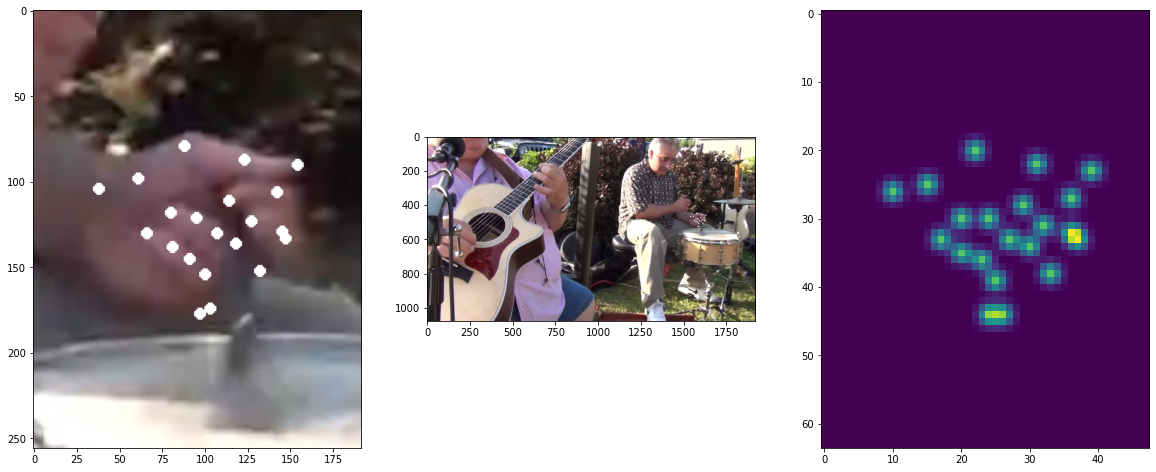

In [9]:
plt_poltter = PLTPoltter(ax_size=(1, 3), figsize=(20, 10))
# plt_poltter.plt_show_cv2_img(bbox_img, 0)
plt_poltter.plt_show_cv2_img(affined_img, 0)
# plt_poltter.plt_show_np_single_channel(target_mask, channel=13, ax_id=1)
plt_poltter.plt_show_np_concat(target_mask, concat_num=21, ax_id=2)
plt_poltter.plt_show_cv2_img(gt_recover_joint_img, 1)

In [10]:
from model import UltraLightSimplePoseNet
from pose_utils.transforms import to_tensor, norm
weight_path = './checkpoints/copy_mobilenetv2_epoch_75_acc1_0.70.pt'
pose_estimator = UltraLightSimplePoseNet().cuda()
pose_estimator.load_state_dict(torch.load(weight_path))
affined_img_bk = to_tensor(affined_img_bk)
affined_img_bk = norm(affined_img_bk, (-0.406, -0.457, -0.480))
affined_img_bk = affined_img_bk.unsqueeze(0).cuda()
pred_mask = pose_estimator(affined_img_bk)
pred_mask_numpy = pred_mask[0].cpu().detach().numpy()

In [11]:
from pose_utils.transforms import heatmap_to_coord_simple
preds, maxvals = heatmap_to_coord_simple(pred_mask_numpy, hand_bbox)
pred_recover_joint_img = copy.deepcopy(full_img)
for pt in preds:
    x, y = pt
    pred_recover_joint_img = cv2.circle(pred_recover_joint_img, center=(int(x), int(y)), radius=2, color=(255, 255, 255), thickness=2)

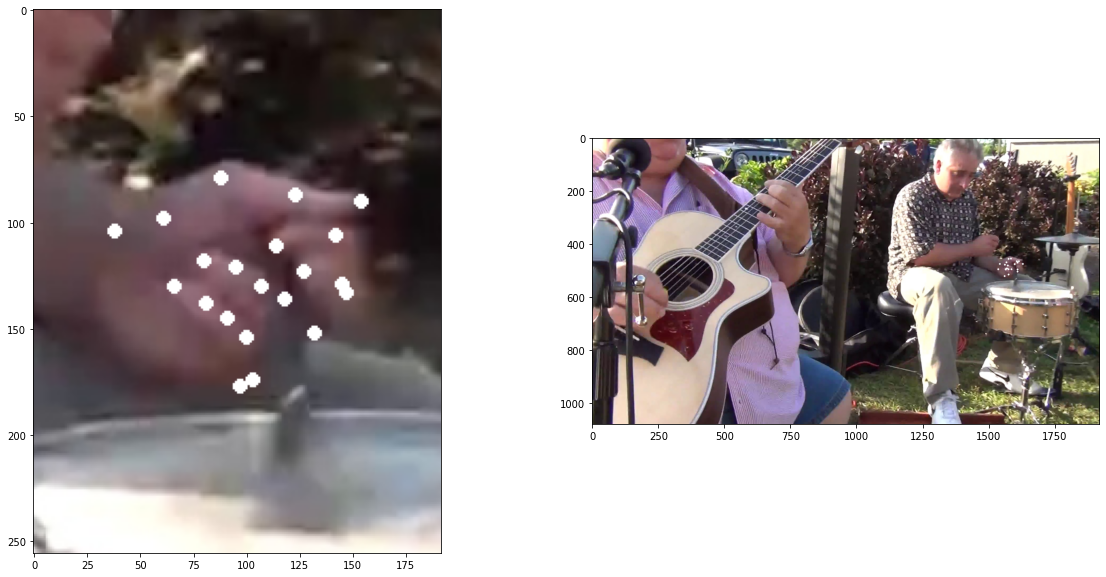

In [12]:

plt_poltter = PLTPoltter(ax_size=(1, 2), figsize=(20, 10))
plt_poltter.plt_show_cv2_img(affined_img, 0)   # drawn with gt
see_channel = 5
# plt_poltter.plt_show_np_single_channel(pred_mask_numpy, channel=see_channel, ax_id=1)
# plt_poltter.plt_show_np_single_channel(target_mask, channel=see_channel, ax_id=2)
# plt_poltter.plt_show_np_concat(pred_mask_numpy, concat_num=21, ax_id=2)
plt_poltter.plt_show_cv2_img(pred_recover_joint_img, 1)